Import libraries

In [ ]:
import pandas as pd
import json

import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler
from sklearn.metrics import classification_report

from A import imdb

Detect GPU device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3070 Ti Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


Read the original IMDB datasets

In [3]:
# Load the IMDB movie review dataset
train_data = imdb.read_imdb("Datasets/aclImdb", "train")
test_data = imdb.read_imdb("Datasets/aclImdb", "test")

Clean, Tokenize and Save the preprocessed datasets (Already run and saved in A/Preprocessed data)

In [ ]:
# Clean the loaded data using the clean_all_texts function
clean_train_data = {"text": imdb.clean_all_texts(train_data), "label": train_data["label"]}
clean_test_data = {"text": imdb.clean_all_texts(test_data), "label": test_data["label"]}

# Initialize a BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the cleaned data
train_token = tokenizer(clean_train_data["text"], padding='max_length', truncation=True, max_length=512)
test_token = tokenizer(clean_test_data["text"], padding='max_length', truncation=True, max_length=512)

# Save the cleaned data as JSON files
with open("A/Preprocessed_Data/clean_train_data.json", "w") as f:
    json.dump(clean_train_data, f)
with open("A/Preprocessed_Data/clean_test_data.json", "w") as f:
    json.dump(clean_test_data, f)

# Save the tokenized data as PyTorch tensors
torch.save(train_token, "A/Preprocessed_Data/train_token.pt")
torch.save(test_token, "A/Preprocessed_Data/test_token.pt")

Load the cleaned and tokenized data and prepare for training and evaluating

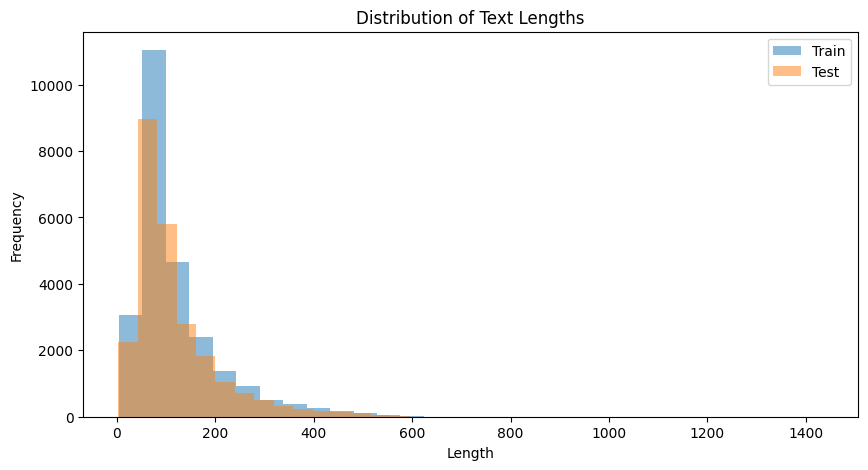

In [5]:
# Load the cleaned and tokenized IMDB movie review data
clean_train_data, clean_test_data, train_token, test_token = imdb.load_imdb_data()

# Calculate the length of each review in the training and testing data
train_lengths = [len(text.split()) for text in clean_train_data["text"]]
test_lengths = [len(text.split()) for text in clean_test_data["text"]]

# Plot the distribution of review lengths in the training and testing data
imdb.plot_length_distribution(train_lengths, test_lengths, "Results/length_distribution.png")

# Select a balanced subset of the testing data
selected_test_data = imdb.select_test(clean_test_data)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the cleaned data
selected_test_token = tokenizer(selected_test_data["text"], padding='max_length', truncation=True, max_length=512)

# Create PyTorch datasets from the tokenized data and labels
train_dataset = imdb.IMDBDataset(train_token, clean_train_data["label"])
test_dataset = imdb.IMDBDataset(selected_test_token, selected_test_data["label"])

# Create PyTorch data loaders from the datasets
# The data loaders will provide batches of data to the model during training and testing
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Compare an example of the original, cleaned and tokenized text

In [6]:
# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Original Text': [train_data["text"][0]],  # Original text from the training data
    'Clean Text': [clean_train_data["text"][0]],  # Cleaned text after preprocessing
    'Tokenized Text': [tokenizer.decode(train_token["input_ids"][0])],  # Decoded text after tokenization
})

# Display the DataFrame
print(comparison_df)

# Save the DataFrame to a CSV file
# 'index=False' is used to prevent the DataFrame's index from being saved to the file
comparison_df.to_csv('Results/comparison_text.csv', index=False)

                                       Original Text  \
0  Bromwell High is a cartoon comedy. It ran at t...   

                                          Clean Text  \
0  bromwell high cartoon comedy ran time programs...   

                                      Tokenized Text  
0  [CLS] bromwell high cartoon comedy ran time pr...  


Load the Pre-trained BERT model and fine-tuned with IMDB datasets

In [ ]:
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
# Move the model to the GPU if available
model.to(device)

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
# Set the number of training epochs
epochs = 3
# Calculate the total number of training steps
total_steps = len(train_loader) * epochs
# Calculate the number of warmup steps
num_warmup_steps = int(0.1 * total_steps)
# Initialize the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)
# Initialize the gradient scaler for mixed precision training
scaler = GradScaler()

# Initialize lists to store the loss and accuracy values for each epoch
train_loss_list, train_accuracy_list = [], []
val_loss_list, val_accuracy_list = [], []

# Train the model for the specified number of epochs
for epoch in range(epochs):
    # Train the model for one epoch and get the training loss and accuracy
    train_loss, train_accuracy = imdb.train(model, train_loader, optimizer, scheduler, scaler)
    # Evaluate the model on the validation data and get the validation loss and accuracy
    val_loss, val_accuracy, predictions, true_labels = imdb.evaluate(model, test_loader)
    # Append the loss and accuracy values to the respective lists
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)
    # Print the loss and accuracy values for this epoch
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Save the fine-tuned model and tokenizer
model.save_pretrained("A/fine_tuned_bert")
tokenizer.save_pretrained("A/fine_tuned_bert")

Load the saved fine-tuned model and evaluate with confusion matrix

Validation Loss: 0.2404, Validation Accuracy: 0.9164


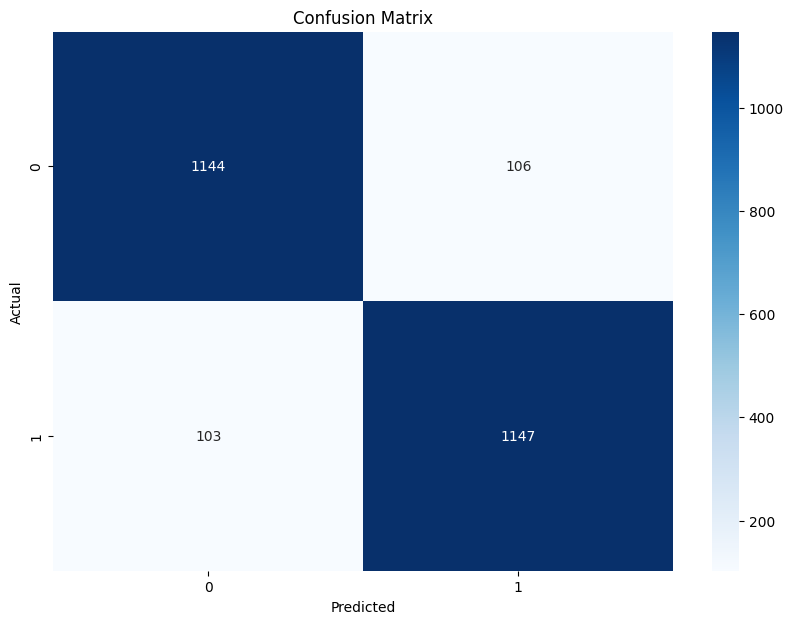

In [14]:
# Load the pre-trained model and tokenizer
imdb_model = BertForSequenceClassification.from_pretrained("A/fine_tuned_bert")
imdb_tokenizer = BertTokenizer.from_pretrained("A/fine_tuned_bert")

# Move the model to the device (GPU or CPU)
imdb_model.to(device)

# Set the model to evaluation mode. This will disable operations specific to training such as dropout
imdb_model.eval()

# Evaluate the model on the test data. This will return the validation loss, validation accuracy, 
# predictions made by the model, and the true labels
val_loss, val_accuracy, predictions, true_labels = imdb.evaluate(imdb_model, test_loader)

# Print the validation loss and accuracy
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plot the confusion matrix using the true labels and the predictions made by the model
imdb.plot_confusion_matrix(true_labels, predictions, "Results/confusion_matrix.png")

Evaluate the fine-tuned Model with some scores

In [13]:
# Generate a classification report. The report includes precision, recall, f1-score, and support for each class.
# The `digits` parameter is used to set the number of digits for the output.
report = classification_report(true_labels, predictions, target_names=['negative', 'positive'], digits=3)
print(report)

# Save the report to a text file
# Open the file in write mode ('w') and write the report to it
with open('Results/prediction_results_report.txt', 'w') as f:
    f.write(report)

              precision    recall  f1-score   support

    negative      0.917     0.915     0.916      1250
    positive      0.915     0.918     0.917      1250

    accuracy                          0.916      2500
   macro avg      0.916     0.916     0.916      2500
weighted avg      0.916     0.916     0.916      2500

